# LSTM on real DNA sequences

In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
import numpy as np
from Bio import SeqIO

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Stop!

In [3]:
"""intr_coords = pd.read_csv('Akey_intr_coords.bed', header = None, sep = "\t")
intr_coords.head()"""

'intr_coords = pd.read_csv(\'Akey_intr_coords.bed\', header = None, sep = "\t")\nintr_coords.head()'

In [4]:
#intr_lengths = intr_coords.iloc[:, 2]-intr_coords.iloc[:, 1]

In [5]:
#print(stats.describe(intr_lengths))

In [6]:
#!zcat hg19.fa.gz | bgzip -c > hg19.fa.bgz

In [7]:
"""a = 0
with open('hg19_intr_regions.fa', 'a') as fp:
    for i in range(intr_coords.shape[0]):
        coord = str(str(intr_coords.iloc[i, 0]) + ':' 
                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')"""

"a = 0\nwith open('hg19_intr_regions.fa', 'a') as fp:\n    for i in range(intr_coords.shape[0]):\n        coord = str(str(intr_coords.iloc[i, 0]) + ':' \n                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))\n        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)\n        a = a + 1\n        if a%10000 == 0:\n            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')"

In [8]:
"""chr_sizes = pd.read_csv("hg19.fa.bgz.fai", header = None, sep = "\t")
chr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)
chr_sizes.head()"""

'chr_sizes = pd.read_csv("hg19.fa.bgz.fai", header = None, sep = "\t")\nchr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)\nchr_sizes.head()'

In [9]:
"""chr_list = []
start_list = []
end_list = []
intr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])
a = 0
for i in range(intr_coords.shape[0]):
    chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])]
    overlap = True
    while overlap == True:
        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords.iloc[i,0]].iloc[:,1]))
        reg_end = reg_start + intr_lengths[i]
        for j in range(chr_df.shape[0]):
            b1 = chr_df.iloc[j,1]
            b2 = chr_df.iloc[j,2]
            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or \
            (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):
                overlap = True
                break
            else:
                overlap = False
    chr_list.append(intr_coords.iloc[i,0])
    start_list.append(reg_start)
    end_list.append(reg_end)
    a = a + 1
    if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')
depl_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
depl_coords.to_csv("Akey_depl_coords.bed", index = False, header = False, sep = "\t")
depl_coords.head()"""

'chr_list = []\nstart_list = []\nend_list = []\nintr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])\na = 0\nfor i in range(intr_coords.shape[0]):\n    chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])]\n    overlap = True\n    while overlap == True:\n        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords.iloc[i,0]].iloc[:,1]))\n        reg_end = reg_start + intr_lengths[i]\n        for j in range(chr_df.shape[0]):\n            b1 = chr_df.iloc[j,1]\n            b2 = chr_df.iloc[j,2]\n            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or             (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):\n                overlap = True\n                break\n            else:\n                overlap = False\n    chr_list.append(intr_coords.iloc[i,0])\n    start_list.append(reg_start)\n    end_list.append(reg_end)\n    a = a + 1\n    if a%10000 == 0:\n            print(\'Fini

In [10]:
#depl_coords = pd.read_csv("Akey_depl_coords.bed", sep = "\t")

In [11]:
#!bedtools intersect -a Akey_intr_coords.bed -b Akey_depl_coords.bed | wc -l

In [12]:
"""a = 0
with open('hg19_depl_regions.fa', 'a') as fp:
    for i in range(depl_coords.shape[0]):
        coord = str(str(depl_coords.iloc[i, 0]) + ':' 
                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal ancestry depleted regions')"""

"a = 0\nwith open('hg19_depl_regions.fa', 'a') as fp:\n    for i in range(depl_coords.shape[0]):\n        coord = str(str(depl_coords.iloc[i, 0]) + ':' \n                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))\n        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)\n        a = a + 1\n        if a%10000 == 0:\n            print('Finished ' + str(a) + ' Neanderthal ancestry depleted regions')"

In [13]:
#!grep -c N hg19_intr_regions.fa

In [14]:
#!grep -c N hg19_depl_regions.fa

In [15]:
"""intr_file = 'hg19_intr_regions.fa'
depl_file = 'hg19_depl_regions.fa'
a = 0
i = 0
with open('hg19_intr_clean.fa', 'a') as intr_out, open('hg19_depl_clean.fa', 'a') as depl_out:
    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
        upper_intr = intr.seq.upper()
        upper_depl = depl.seq.upper()
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):
            intr.seq = upper_intr
            SeqIO.write(intr, intr_out, 'fasta')
            depl.seq = upper_depl
            SeqIO.write(depl, depl_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')"""

"intr_file = 'hg19_intr_regions.fa'\ndepl_file = 'hg19_depl_regions.fa'\na = 0\ni = 0\nwith open('hg19_intr_clean.fa', 'a') as intr_out, open('hg19_depl_clean.fa', 'a') as depl_out:\n    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):\n        upper_intr = intr.seq.upper()\n        upper_depl = depl.seq.upper()\n        a = a + 1\n        if a%10000 == 0:\n            print('Finished ' + str(a) + ' entries')\n        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):\n            intr.seq = upper_intr\n            SeqIO.write(intr, intr_out, 'fasta')\n            depl.seq = upper_depl\n            SeqIO.write(depl, depl_out, 'fasta')\n            i = i + 1\n        else:\n            continue\nprint('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')"

In [16]:
#!grep -c N hg19_intr_regions.fa

In [17]:
#!grep -c N hg19_depl_regions.fa

# START HERE

Qui il codice commentato è perché volevo fare un po' di prove, quindi può essere cambiato a piacimento

Attenzione perché la rete così com'è ci mette tanto ad allenarsi.

In [18]:
intr_file = '../data/hg19_intr_clean.fa'
depl_file = '../data/hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    #cutoff = 200
    #my_intr_seq = str(intr.seq)[0:cutoff]
    #my_depl_seq = str(depl.seq)[0:cutoff]
    #intr_seqs.append(my_intr_seq)
    #depl_seqs.append(my_depl_seq)
    
    step = 200; jump = 1; a = 0; b = step; n_jumps = 5
    for j in range(n_jumps):
        s_intr = str(intr.seq)[a:b]
        s_depl = str(depl.seq)[a:b]
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
        a = a + jump
        b = a + step
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 10
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [19]:
print(intr_texts[0:100])
print(depl_texts[0:100])

['GGATGCCCTC GATGCCCTCA ATGCCCTCAA TGCCCTCAAT GCCCTCAATG CCCTCAATGG CCTCAATGGC CTCAATGGCA TCAATGGCAG CAATGGCAGC AATGGCAGCA ATGGCAGCAG TGGCAGCAGC GGCAGCAGCC GCAGCAGCCC CAGCAGCCCA AGCAGCCCAT GCAGCCCATC CAGCCCATCT AGCCCATCTC GCCCATCTCT CCCATCTCTG CCATCTCTGG CATCTCTGGG ATCTCTGGGC TCTCTGGGCA CTCTGGGCAC TCTGGGCACC CTGGGCACCA TGGGCACCAT GGGCACCATG GGCACCATGC GCACCATGCA CACCATGCAG ACCATGCAGA CCATGCAGAG CATGCAGAGC ATGCAGAGCA TGCAGAGCAG GCAGAGCAGT CAGAGCAGTC AGAGCAGTCC GAGCAGTCCA AGCAGTCCAC GCAGTCCACC CAGTCCACCA AGTCCACCAG GTCCACCAGC TCCACCAGCA CCACCAGCAT CACCAGCATC ACCAGCATCT CCAGCATCTG CAGCATCTGG AGCATCTGGC GCATCTGGCT CATCTGGCTG ATCTGGCTGC TCTGGCTGCA CTGGCTGCAT TGGCTGCATG GGCTGCATGT GCTGCATGTG CTGCATGTGG TGCATGTGGA GCATGTGGAT CATGTGGATA ATGTGGATAA TGTGGATAAT GTGGATAATG TGGATAATGC GGATAATGCC GATAATGCCA ATAATGCCAC TAATGCCACT AATGCCACTG ATGCCACTGA TGCCACTGAG GCCACTGAGG CCACTGAGGT CACTGAGGTG ACTGAGGTGT CTGAGGTGTG TGAGGTGTGG GAGGTGTGGT AGGTGTGGTC GGTGTGGTCT GTGTGGTCTT TGTGGTCTTG GTGGTCTTGG TGGTCTTG

In [20]:
merge_texts = intr_texts + depl_texts
len(merge_texts)

733640

In [21]:
print(merge_texts[0:200])

['GGATGCCCTC GATGCCCTCA ATGCCCTCAA TGCCCTCAAT GCCCTCAATG CCCTCAATGG CCTCAATGGC CTCAATGGCA TCAATGGCAG CAATGGCAGC AATGGCAGCA ATGGCAGCAG TGGCAGCAGC GGCAGCAGCC GCAGCAGCCC CAGCAGCCCA AGCAGCCCAT GCAGCCCATC CAGCCCATCT AGCCCATCTC GCCCATCTCT CCCATCTCTG CCATCTCTGG CATCTCTGGG ATCTCTGGGC TCTCTGGGCA CTCTGGGCAC TCTGGGCACC CTGGGCACCA TGGGCACCAT GGGCACCATG GGCACCATGC GCACCATGCA CACCATGCAG ACCATGCAGA CCATGCAGAG CATGCAGAGC ATGCAGAGCA TGCAGAGCAG GCAGAGCAGT CAGAGCAGTC AGAGCAGTCC GAGCAGTCCA AGCAGTCCAC GCAGTCCACC CAGTCCACCA AGTCCACCAG GTCCACCAGC TCCACCAGCA CCACCAGCAT CACCAGCATC ACCAGCATCT CCAGCATCTG CAGCATCTGG AGCATCTGGC GCATCTGGCT CATCTGGCTG ATCTGGCTGC TCTGGCTGCA CTGGCTGCAT TGGCTGCATG GGCTGCATGT GCTGCATGTG CTGCATGTGG TGCATGTGGA GCATGTGGAT CATGTGGATA ATGTGGATAA TGTGGATAAT GTGGATAATG TGGATAATGC GGATAATGCC GATAATGCCA ATAATGCCAC TAATGCCACT AATGCCACTG ATGCCACTGA TGCCACTGAG GCCACTGAGG CCACTGAGGT CACTGAGGTG ACTGAGGTGT CTGAGGTGTG TGAGGTGTGG GAGGTGTGGT AGGTGTGGTC GGTGTGGTCT GTGTGGTCTT TGTGGTCTTG GTGGTCTTGG TGGTCTTG

In [22]:
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

733640


In [23]:
#cv = CountVectorizer()
#X = cv.fit_transform(merge_texts)

#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)
#X = tokenizer.texts_to_matrix(merge_texts, mode = 'freq')

encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

print(X)
print('\n')
print(X.shape)

[[153634 568397 382160 ... 635443 506832 658088]
 [568397 382160 380712 ... 506832 658088 654350]
 [382160 380712 323461 ... 658088 654350 503434]
 ...
 [  1173    900    397 ...  64841  93299 115195]
 [   900    397    537 ...  93299 115195 135311]
 [   397    537   1117 ... 115195 135311  63747]]


(733640, 191)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

In [25]:
print(X_train.shape)
print(X_test.shape)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

(586912, 191)
(146728, 191)


In [26]:
max_length = max([len(s.split()) for s in merge_texts])
print(max_length)

191


In [27]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

944238


In [28]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, 10)) #dropout = 0.2 #input_length = max_length
#model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', activation = 'relu'))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(LSTM(10)) #dropout = 0.2, recurrent_dropout = 0.2
model.add(Bidirectional(LSTM(10))) #dropout = 0.2, recurrent_dropout = 0.2
#model.add(Bidirectional(SimpleRNN(10)))
#model.add(GRU(10))
#model.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))
#model.add(Flatten())
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.0001), metrics = ['accuracy'])
checkpoint = ModelCheckpoint("/home/ubuntu/Ragu/LSTM.weights.best.hdf5", monitor = 'val_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'max')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          9442380   
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                1680      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 9,444,281
Trainable params: 9,444,281
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 469529 samples, validate on 117383 samples
Epoch 1/5
469504/469529 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.8818
Epoch 00001: val_accuracy improved from -inf to 0.97814, saving model to /home/ubuntu/Ragu/LSTM.weights.best.hdf5
469529/469529 [==============================] - 1876s 4ms/sample - loss: 0.2372 - accuracy: 0.8818 - val_loss: 0.0563 - val_accuracy: 0.9781
Epoch 2/5
469504/469529 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9936
Epoch 00002: val_accuracy improved from 0.97814 to 0.99016, saving model to /home/ubuntu/Ragu/LSTM.weights.best.hdf5
469529/469529 [==============================] - 1873s 4ms/sample - loss: 0.0182 - accuracy: 0.9935 - val_loss: 0.0280 - val_accuracy: 0.9902
Epoch 3/5
469504/469529 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9988
Epoch 00003: val_accuracy improved from 0.99016 to 0.99518, saving model to /home/ubuntu/Ragu/LSTM.weights.best.hdf5
469529/469529

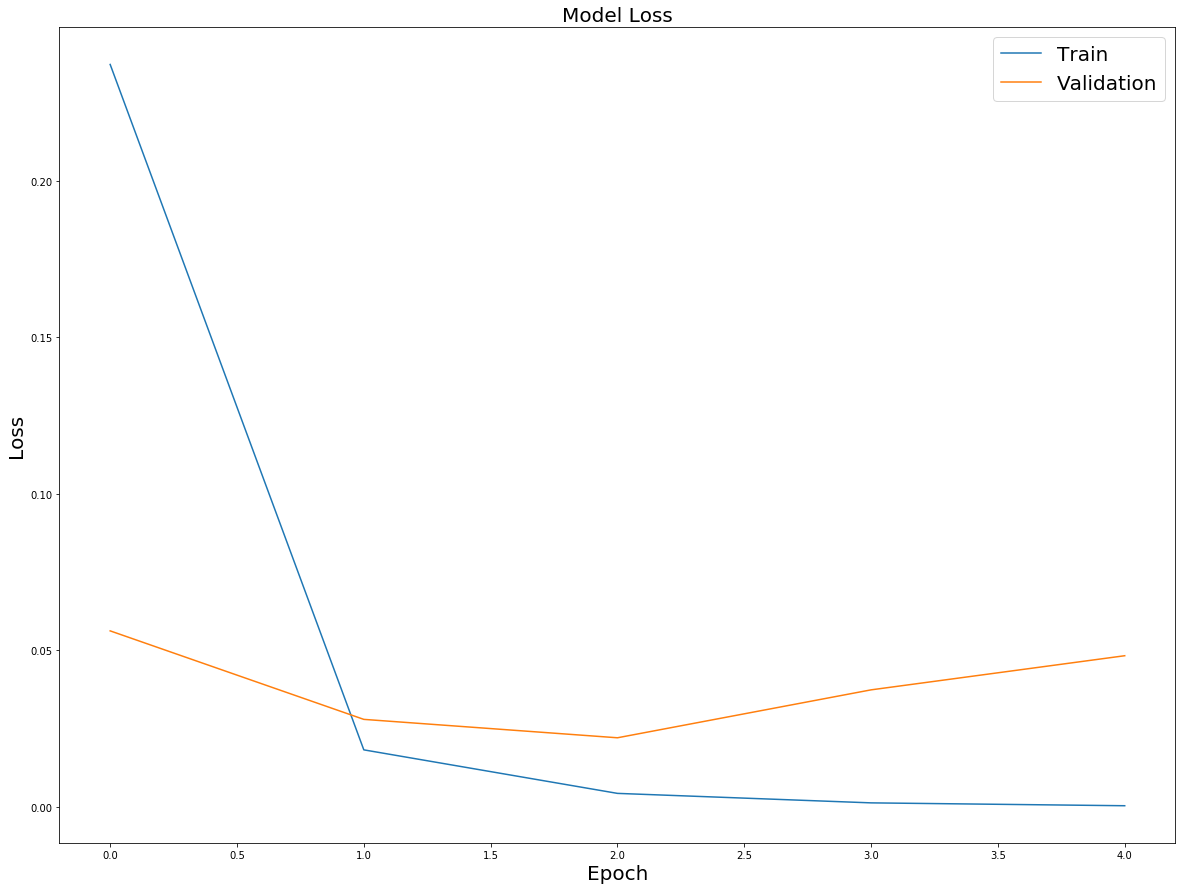

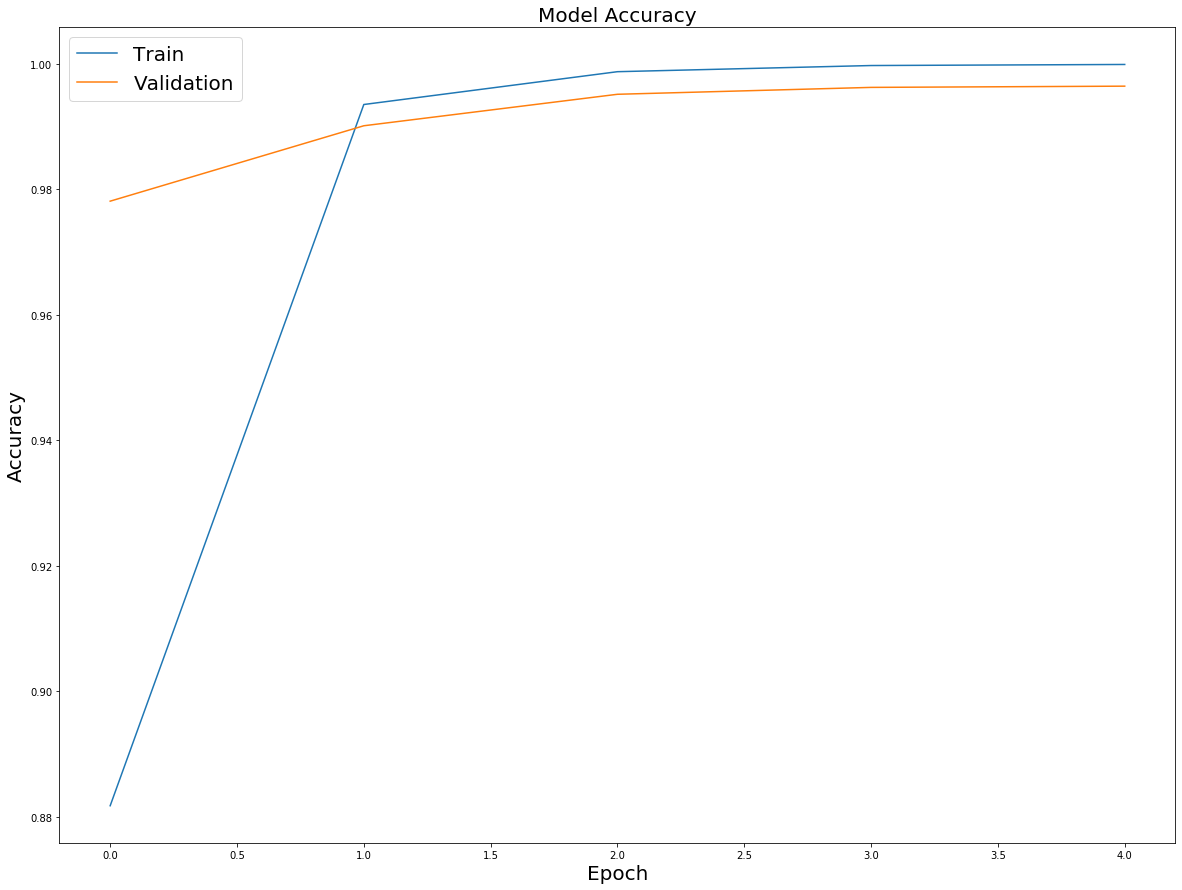

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Confusion matrix:
 [[73147   211]
 [  277 73093]]


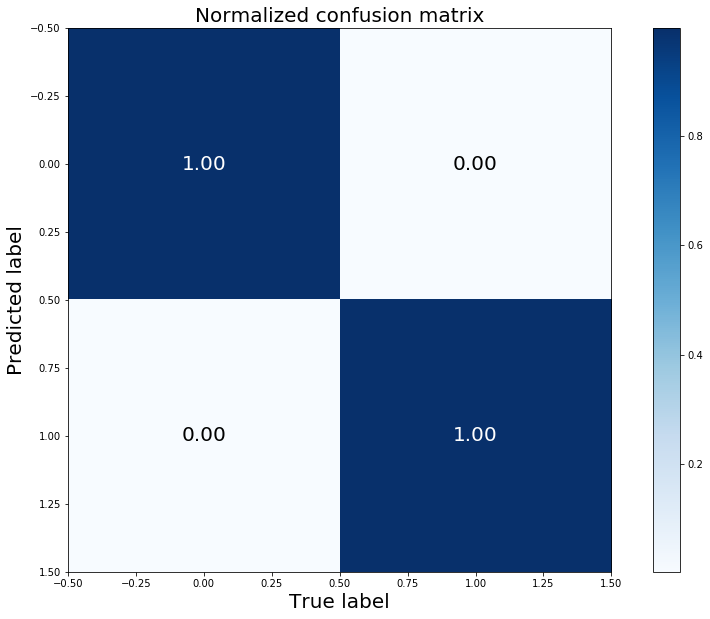

In [31]:
plt.figure(figsize = (15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [32]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 99.67%


In [33]:
model.load_weights("LSTM.weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [34]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(944238, 10)


In [35]:
model = Sequential()
model.add(Embedding(vocab_size, 10))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.load_weights("LSTM.weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          9442380   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                1680      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 9,444,281
Trainable params: 9,444,281
Non-trainable params: 0
_________________________________________________________________


In [36]:
X_test.shape

(146728, 191)

In [37]:
np.savetxt('X_test.txt', X_test)

In [39]:
X_test_read = np.int32(np.loadtxt('X_test.txt')).reshape((146728, 191))

In [40]:
X_test_orig = X_test

In [42]:
import random
j = 1
X_test_orig = np.int32(np.loadtxt('X_test.txt')).reshape((146728, 191))
X_test_perm = X_test_orig
X_test_perm[:,j] = random.sample(list(X_test_orig[:,j]), len(list(X_test_orig[:,j])))
X_test_perm[0:5, 0:5]

array([[298318, 269068, 222166,  71640, 114628],
       [392768, 287638, 531160, 508433, 289695],
       [ 82155, 272408, 129630, 147829, 168133],
       [ 36052, 246828, 180160, 333096, 468005],
       [ 96452, 255658,  58492, 456681,  46166]], dtype=int32)

In [44]:
scores = model.evaluate(X_test_perm, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 99.67%


In [46]:
perm_scores = []
for i in range(X_test.shape[1]):
    print(i)
    X_test_orig = np.int32(np.loadtxt('X_test.txt')).reshape((146728, 191))
    X_test_perm = X_test_orig
    X_test_perm[:,i] = random.sample(list(X_test[:,i]), len(list(X_test[:,i])))
    perm_scores.append(abs(model.evaluate(X_test_perm, y_test, verbose = 0)[1]*100 - 99.66))
    print(perm_scores)

0
[0.007412042617801262]
1
[0.007412042617801262, 0.010135974884036614]
2
[0.007412042617801262, 0.010135974884036614, 0.007412042617801262]
3
[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716]
4
[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606]
5
[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059]
6
[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403]
7
[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606]
8
[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504]
28
[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.00673

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653]
40
[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.0

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

[0.007412042617801262, 0.010135974884036614, 0.007412042617801262, 0.00945648193359716, 0.010821428298953606, 0.011500921249393059, 0.014910306930545403, 0.010821428298953606, 0.010821428298953606, 0.005367603302005364, 0.010821428298953606, 0.00195821762085302, 0.013545360565188957, 0.014910306930545403, 0.006047096252444817, 0.005367603302005364, 0.004688110351565911, 0.006732549667361809, 0.011500921249393059, 0.010135974884036614, 0.0012787246704135669, 0.007412042617801262, 0.004688110351565911, 0.011500921249393059, 0.0005992317199741137, 0.011500921249393059, 0.015589799880984856, 0.012865867614749504, 0.002643671035770012, 0.013545360565188957, 0.012180414199832512, 0.014910306930545403, 0.007412042617801262, 0.008091535568240715, 0.011500921249393059, 0.0005992317199741137, 0.006732549667361809, 0.010821428298953606, 0.0005992317199741137, 0.0033231639862094653, 0.010821428298953606, 0.00195821762085302, 0.008091535568240715, 0.008776988983157707, 0.007412042617801262, 0.00059

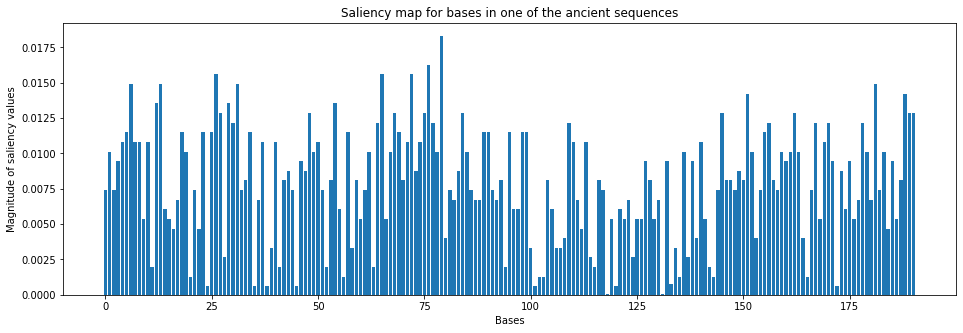

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(perm_scores)), perm_scores)
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
#plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the ancient sequences')
plt.show()

In [48]:
import pandas as pd
scores_df = pd.DataFrame({'Base': range(len(perm_scores)),'Score': perm_scores})
scores_df.to_csv('scores_df.txt', index = False, sep = '\t')
scores_df[scores_df['Score'] > 0.01]

,Base,Score
1,1,0.010136
4,4,0.010821
5,5,0.011501
6,6,0.014910
7,7,0.010821
...,...,...
181,181,0.014910
183,183,0.010136
188,188,0.014225
189,189,0.012866


In [49]:
informative_indeces = list(scores_df[scores_df['Score'] > 0.01].index)
informative_indeces

[1,
 4,
 5,
 6,
 7,
 8,
 10,
 12,
 13,
 18,
 19,
 23,
 25,
 26,
 27,
 29,
 30,
 31,
 34,
 37,
 40,
 48,
 49,
 50,
 54,
 57,
 62,
 64,
 65,
 67,
 68,
 69,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 84,
 85,
 89,
 90,
 95,
 98,
 99,
 109,
 110,
 113,
 136,
 140,
 145,
 151,
 152,
 155,
 156,
 159,
 161,
 162,
 163,
 167,
 169,
 170,
 178,
 179,
 181,
 183,
 188,
 189,
 190]

In [50]:
X_test[informative_indeces, 0:5]

array([[392768, 465682, 531160, 508433, 289695],
       [ 96452, 143454,  58492, 456681,  46166],
       [ 14490, 176400,  63814,  71471, 138615],
       [ 33814, 132267, 246793,  57224, 423945],
       [ 11162,   5594,   6692,  26133,   7231],
       [716585, 658117, 690758, 566195, 536272],
       [121740, 152396,  68773,  25577,   7491],
       [171944, 115206,  85550, 103892,  40506],
       [352878, 289909,  65309,  30183,   7073],
       [277097, 285648, 428785, 299544,  33257],
       [155004, 319869, 341717, 409453, 398782],
       [  9267,  15248,  19343,  27310,   2512],
       [555824, 402421, 519117, 759285, 324554],
       [  4494,   4445,   4938,   4708,   1681],
       [709387, 746368, 840327, 526020, 627567],
       [517171, 332139, 318824, 259603, 192078],
       [224663, 467400,  64946, 129687, 107460],
       [331953,  70804, 270081, 503961, 554606],
       [ 53346,  19988,  31979,  41229,  12532],
       [ 76407, 189421, 233459, 395245, 262065],
       [504015, 4848

In [51]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(list_of_indices):
    return [reverse_word_map.get(letter) for letter in list_of_indices]
my_texts = list(map(sequence_to_text, X_test[informative_indeces, :]))
my_texts[0][0:5]

['acataggctt', 'cataggcttg', 'ataggcttgc', 'taggcttgct', 'aggcttgctg']

In [52]:
len([item for sublist in my_texts for item in sublist])

13561

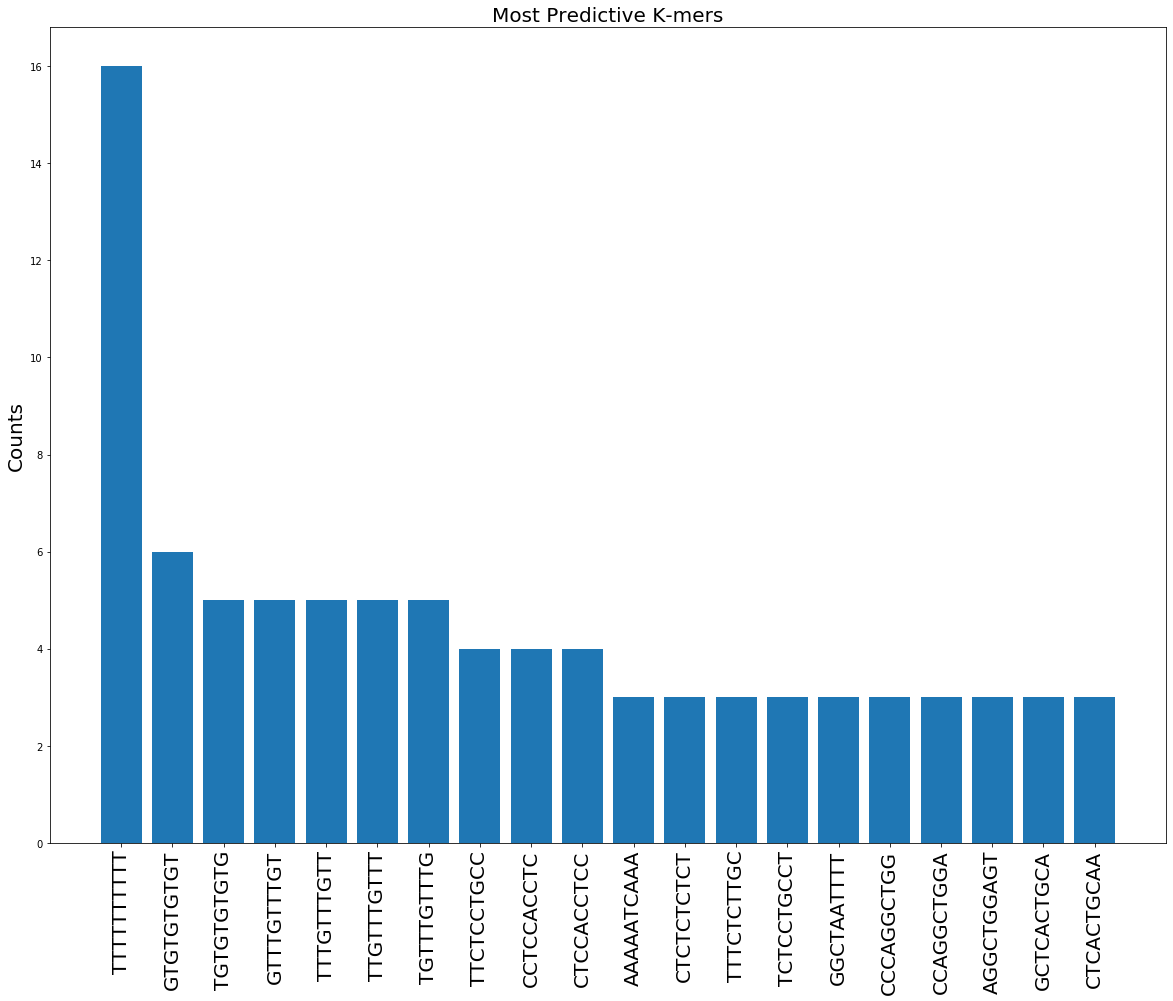

In [53]:
from collections import Counter
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 15))

D = dict(Counter([item.upper() for sublist in my_texts for item in sublist]).most_common(20))
plt.bar(range(len(D)), list(D.values()), align = 'center')
plt.title('Most Predictive K-mers', fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.xticks(rotation = 90)
plt.xticks(range(len(D)), list(D.keys()), fontsize = 20)
plt.show()

# CNN

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation

import warnings
warnings.filterwarnings('ignore')

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length = max_length))
#model.add(Dropout(0.5))
model.add(Conv1D(filters = 16, kernel_size = 5, activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))

model.add(Flatten())
#model.add(Dense(8, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 50
lrate = 0.0001
decay = lrate / epochs
#sgd = SGD(lr = lrate, momentum = 0.99, nesterov = True)
sgd = SGD(lr = lrate, momentum = 0.9, nesterov = False)
#sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['binary_accuracy'])
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
checkpoint = ModelCheckpoint("/home/ubuntu/Ragu/weights.cnn.hdf5", monitor = 'val_binary_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'max')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 191, 10)           9442380   
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 16)           816       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 93, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1488)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1489      
Total params: 9,444,685
Trainable params: 9,444,685
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 469529 samples, validate on 117383 samples
Epoch 1/50
469440/469529 [============================>.] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.5006
Epoch 00001: val_binary_accuracy improved from -inf to 0.50286, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/469529 [==============================] - 124s 263us/sample - loss: 0.6932 - binary_accuracy: 0.5006 - val_loss: 0.6932 - val_binary_accuracy: 0.5029
Epoch 2/50
469440/469529 [============================>.] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.5027
Epoch 00002: val_binary_accuracy did not improve from 0.50286
469529/469529 [==============================] - 126s 268us/sample - loss: 0.6932 - binary_accuracy: 0.5028 - val_loss: 0.6932 - val_binary_accuracy: 0.5011
Epoch 3/50
469344/469529 [============================>.] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.5040
Epoch 00003: val_binary_accuracy improved from 0.50286 to 0.50588, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/46952

Epoch 23/50
469344/469529 [============================>.] - ETA: 0s - loss: 0.6920 - binary_accuracy: 0.5334
Epoch 00023: val_binary_accuracy improved from 0.52590 to 0.52606, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/469529 [==============================] - 109s 232us/sample - loss: 0.6920 - binary_accuracy: 0.5334 - val_loss: 0.6922 - val_binary_accuracy: 0.5261
Epoch 24/50
469504/469529 [============================>.] - ETA: 0s - loss: 0.6919 - binary_accuracy: 0.5361
Epoch 00024: val_binary_accuracy improved from 0.52606 to 0.52779, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/469529 [==============================] - 121s 257us/sample - loss: 0.6919 - binary_accuracy: 0.5361 - val_loss: 0.6922 - val_binary_accuracy: 0.5278
Epoch 25/50
469312/469529 [============================>.] - ETA: 0s - loss: 0.6918 - binary_accuracy: 0.5362
Epoch 00025: val_binary_accuracy did not improve from 0.52779
469529/469529 [==============================] - 118s 252u

469529/469529 [==============================] - 145s 309us/sample - loss: 0.6724 - binary_accuracy: 0.5896 - val_loss: 0.6723 - val_binary_accuracy: 0.5882
Epoch 46/50
469376/469529 [============================>.] - ETA: 0s - loss: 0.6691 - binary_accuracy: 0.5947
Epoch 00046: val_binary_accuracy improved from 0.58821 to 0.59365, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/469529 [==============================] - 136s 290us/sample - loss: 0.6691 - binary_accuracy: 0.5946 - val_loss: 0.6693 - val_binary_accuracy: 0.5936
Epoch 47/50
469504/469529 [============================>.] - ETA: 0s - loss: 0.6654 - binary_accuracy: 0.6001
Epoch 00047: val_binary_accuracy did not improve from 0.59365
469529/469529 [==============================] - 123s 263us/sample - loss: 0.6654 - binary_accuracy: 0.6001 - val_loss: 0.6661 - val_binary_accuracy: 0.5849
Epoch 48/50
469504/469529 [============================>.] - ETA: 0s - loss: 0.6614 - binary_accuracy: 0.6064
Epoch 00048: val_bi

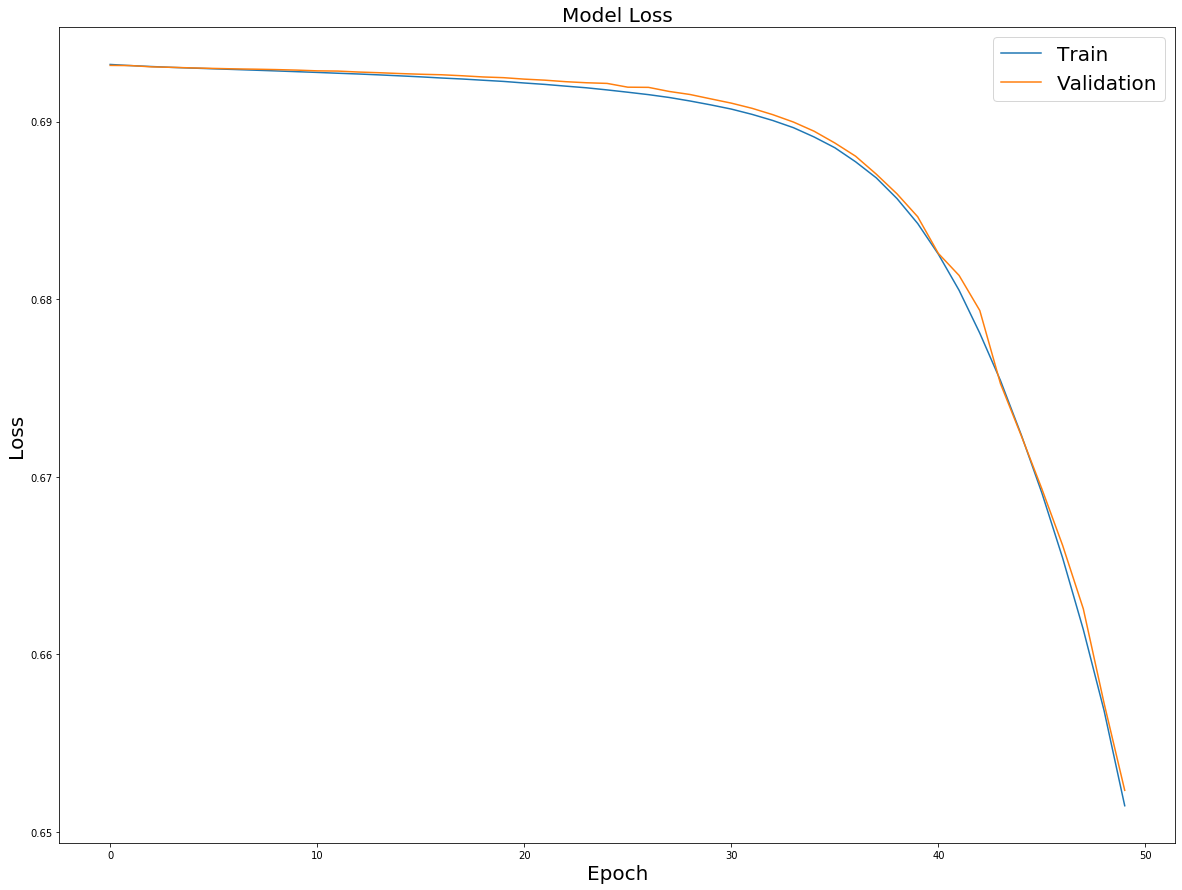

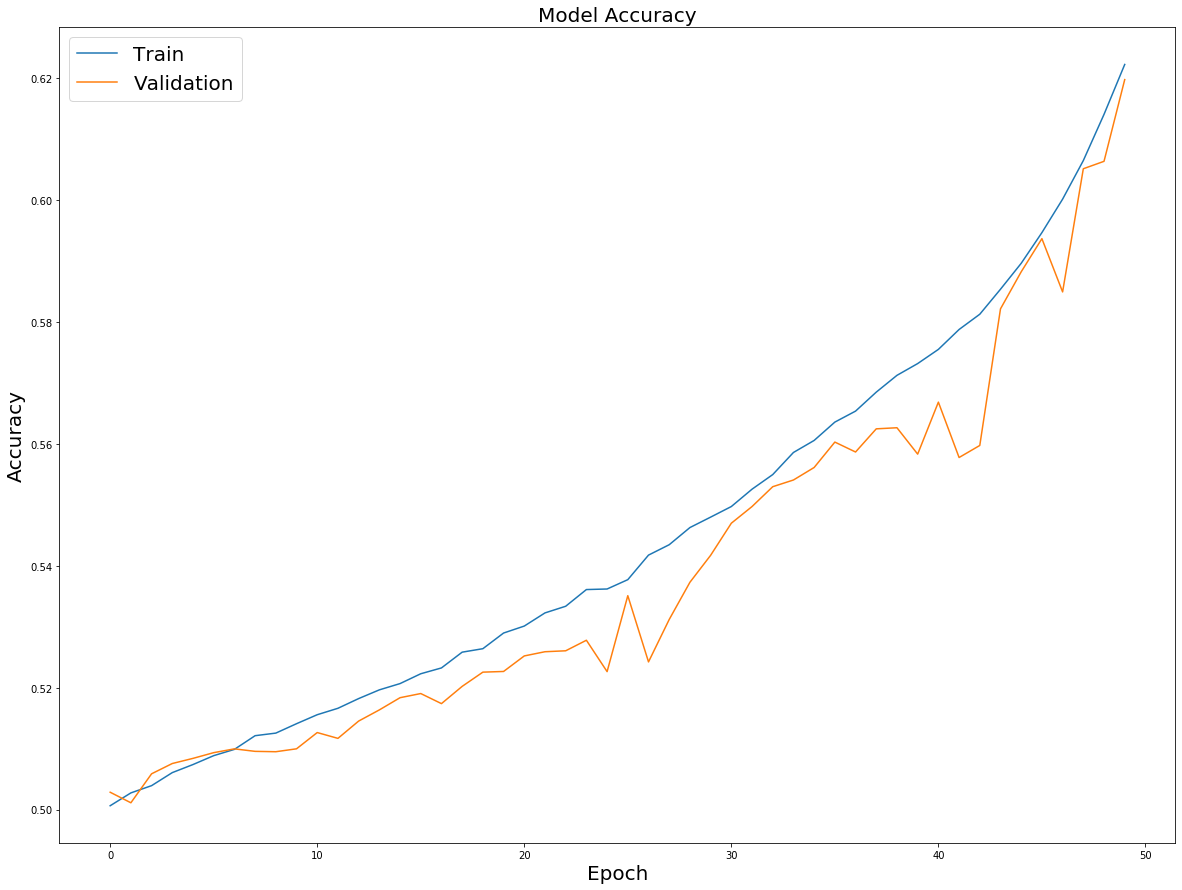

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

In [64]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Confusion matrix:
 [[42095 31263]
 [24428 48942]]


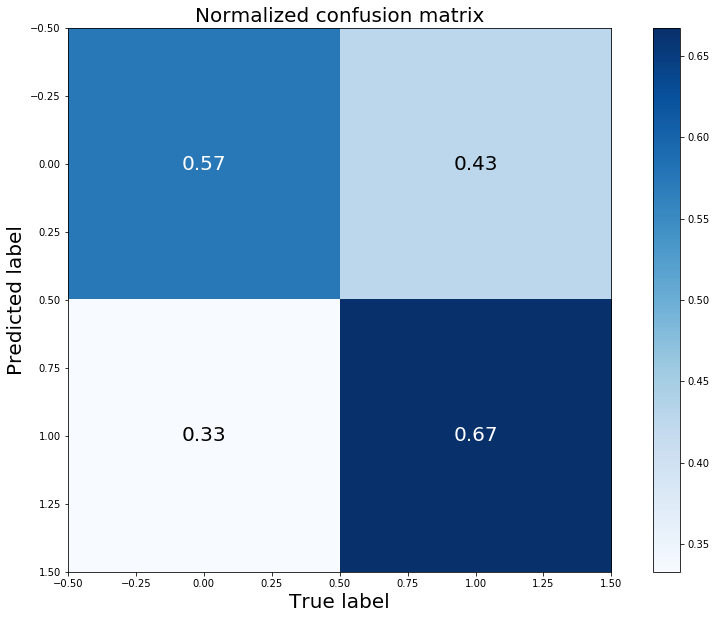

In [65]:
plt.figure(figsize = (15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [66]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 62.04%


# Genes

In [1]:
from Bio import SeqIO

gene_file = 'hg19_gene_clean.fa'

e = 0
gene_seqs = []
gene_ids = []
for gene in SeqIO.parse('/home/ubuntu/data/' + gene_file, 
                        'fasta'):
    #step = 200; jump = 1; a = 0; b = step; n_jumps = 5
    
    cutoff = 200
    if len(str(gene.seq)) < cutoff:
        continue
    
    #if len(str(gene.seq)) < (step + 1) * n_jumps:
    #    continue
    
    gene_ids.append(str(gene.id))
    s_gene = str(gene.seq)[0:cutoff]
    gene_seqs.append(s_gene)
    
    #for j in range(n_jumps):
    #    s_gene = str(gene.seq)[a:b]
    #    gene_seqs.append(s_gene)
    #    a = a + jump
    #    b = a + step
    
    e = e + 1
    if e%10000 == 0:
        print('Finished ' + str(e) + ' genes')

def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 10
gene_texts = [' '.join(getKmers(i, kmer)) for i in gene_seqs]

Finished 10000 genes
Finished 20000 genes
Finished 30000 genes


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(gene_texts)

encoded_docs = tokenizer.texts_to_sequences(gene_texts)
max_length = max([len(s.split()) for s in gene_texts])
X_gene = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

print(X_gene)
print('\n')
print(X_gene.shape)

Using TensorFlow backend.


[[547859 642875 642876 ... 125875 110809  77277]
 [253351 294309 164774 ...  31487 125876 218639]
 [164781  61751 110810 ... 253371 218650 294330]
 ...
 [300782 349547 453994 ...  14457  10644  10929]
 [ 63780 142785 252925 ...  53054 543738 324349]
 [273128 360570 109937 ... 219163  82309 120347]]


(35549, 191)


In [5]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

891013


In [7]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional

model = Sequential()
model.add(Embedding(944238, 10))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.load_weights("LSTM.weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          9442380   
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                1680      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 9,444,281
Trainable params: 9,444,281
Non-trainable params: 0
_________________________________________________________________


In [8]:
gene_predictions = model.predict_classes(X_gene)
gene_predictions_prob = model.predict_proba(X_gene)

In [9]:
X_gene.shape

(35549, 191)

In [10]:
gene_predictions.shape

(35549, 1)

In [11]:
gene_predictions_prob.shape

(35549, 1)

In [12]:
gene_ids

['chr1:11869-14362',
 'chr1:11874-14409',
 'chr1:14362-29370',
 'chr1:34611-36081',
 'chr1:34611-36081',
 'chr1:69091-70008',
 'chr1:134773-140566',
 'chr1:323892-328581',
 'chr1:367659-368597',
 'chr1:367659-368597',
 'chr1:367659-368597',
 'chr1:562760-564389',
 'chr1:621096-622034',
 'chr1:752751-755214',
 'chr1:761586-762902',
 'chr1:762971-778984',
 'chr1:762971-794826',
 'chr1:763178-794826',
 'chr1:803451-812182',
 'chr1:852198-855072',
 'chr1:879583-894636',
 'chr1:895964-901099',
 'chr1:910578-916553',
 'chr1:910578-917473',
 'chr1:934344-935477',
 'chr1:948877-949919',
 'chr1:955500-991494',
 'chr1:969373-991494',
 'chr1:1006347-1009686',
 'chr1:1017203-1051469',
 'chr1:1072397-1079434',
 'chr1:1109260-1133315',
 'chr1:1115061-1121243',
 'chr1:1146720-1149533',
 'chr1:1152311-1167381',
 'chr1:1167617-1170420',
 'chr1:1189292-1209234',
 'chr1:1215816-1227405',
 'chr1:1243960-1247057',
 'chr1:1243977-1247057',
 'chr1:1246965-1260067',
 'chr1:1246980-1260040',
 'chr1:1260182-126

In [13]:
import pickle

with open('gene_ids_LSTM.txt', 'w') as f:
    for item in gene_ids:
        f.write("%s\n" % item)

In [14]:
!cat gene_ids_LSTM.txt

chr1:11869-14362
chr1:11874-14409
chr1:14362-29370
chr1:34611-36081
chr1:34611-36081
chr1:69091-70008
chr1:134773-140566
chr1:323892-328581
chr1:367659-368597
chr1:367659-368597
chr1:367659-368597
chr1:562760-564389
chr1:621096-622034
chr1:752751-755214
chr1:761586-762902
chr1:762971-778984
chr1:762971-794826
chr1:763178-794826
chr1:803451-812182
chr1:852198-855072
chr1:879583-894636
chr1:895964-901099
chr1:910578-916553
chr1:910578-917473
chr1:934344-935477
chr1:948877-949919
chr1:955500-991494
chr1:969373-991494
chr1:1006347-1009686
chr1:1017203-1051469
chr1:1072397-1079434
chr1:1109260-1133315
chr1:1115061-1121243
chr1:1146720-1149533
chr1:1152311-1167381
chr1:1167617-1170420
chr1:1189292-1209234
chr1:1215816-1227405
chr1:1243960-1247057
chr1:1243977-1247057
chr1:1246965-1260067
chr1:1246980-1260040
chr1:1260182-1264276
chr1:1266660-1270694
chr1:1270658-1284798
chr1:1288069-1293927
chr1:1288069-1294174
chr1:1288069-1298921
chr1:1288071-1293935
chr1:1288071-1297179
chr1:1309116-13105

chr17:40834549-40852011
chr17:40852293-40897058
chr17:40905947-40913275
chr17:40913245-40915059
chr17:40932628-40949084
chr17:40949643-40950722
chr17:40950879-40963605
chr17:40962150-40975897
chr17:40962150-40976333
chr17:40962152-40976300
chr17:40985414-40995777
chr17:40996597-41002724
chr17:41003201-41010147
chr17:41005260-41010147
chr17:41052816-41066455
chr17:41102543-41116471
chr17:41102543-41132020
chr17:41102543-41132545
chr17:41120120-41132097
chr17:41132582-41147159
chr17:41150290-41154971
chr17:41150436-41154971
chr17:41158801-41166473
chr17:41166624-41174402
chr17:41177248-41184058
chr17:41196312-41277381
chr17:41300384-41322420
chr17:41323231-41363707
chr17:41363894-41372057
chr17:41373437-41380647
chr17:41373437-41381062
chr17:41447213-41466266
chr17:41453296-41466266
chr17:41476361-41478505
chr17:41561233-41601686
chr17:41561343-41604189
chr17:41605214-41607803
chr17:41605214-41623708
chr17:41717758-41739290
chr17:41843494-41856345
chr17:41857803-41864982
chr17:41878167-4

chr5:149432854-149492935
chr5:149432858-149466117
chr5:149432858-149492928
chr5:149493402-149535408
chr5:149531902-149535408
chr5:149546341-149564121
chr5:149569625-149590626
chr5:149599054-149669336
chr5:149599054-149669403
chr5:149599054-149669693
chr5:149675906-149682468
chr5:149737202-149779871
chr5:149737260-149764201
chr5:149737260-149779856
chr5:149779604-149792319
chr5:149781200-149792499
chr5:149822198-149829302
chr5:149855079-149865555
chr5:149877341-149937773
chr5:149887693-149937773
chr5:149980638-150033794
chr5:149997206-150031903
chr5:150020222-150033794
chr5:150040403-150058930
chr5:150040813-150058930
chr5:150070354-150080624
chr5:150088309-150138082
chr5:150088309-150138657
chr5:150157508-150176298
chr5:150226083-150281964
chr5:150226085-150228231
chr5:150273954-150284545
chr5:150309998-150326146
chr5:150409504-150444692
chr5:150409504-150460645
chr5:150409506-150460595
chr5:150409506-150466727
chr5:150409506-150467246
chr5:150480267-150521245
chr5:150480267-150537340


In [26]:
gene_ids = []
gene_symbol = []
with open('gene_ids_LSTM.txt','r') as fin:
    for line in fin:
        line = line.split('\t')
        print(line)
        gene_ids.append(line[0])
        gene_symbol.append(line[1].rstrip())

['chr1:11869-14362\n']


IndexError: list index out of range

In [27]:
import pandas as pd
gene_pred_df = pd.DataFrame({'Gene': gene_ids, 'Gene_Symbol': gene_symbol, 
                             'Predict': list(gene_predictions.flatten()), 
                             'Prob': list(gene_predictions_prob.flatten())})
gene_pred_df = gene_pred_df.sort_values(['Prob'], ascending = False)
gene_pred_df[(gene_pred_df['Predict'] == 1) & (gene_pred_df['Prob'] > 0.8)]

ValueError: arrays must all be same length

In [ ]:
gene_pred_df.to_csv('Neanderthal_Genes_LSTM.txt', index = False, sep = '\t')